#### Imports

In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf 
import matplotlib as mlt
import joblib

import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
sys.path.append("../src")  # adjust path as needed
from data_generator import data_generator_simple_nn
from model import cnn_models
from tensorflow.keras import models
from sklearn.model_selection import train_test_split


### Load the data

In [2]:
output_dir = '/Users/pushpita/Documents/ML Projects/Project3/data/csv_files/diffusion0.1/'

holdout = 10
nsteps = 5
x_resolution = 100
dim=1           #Load u(x, t), x and t as input

data = data_generator_simple_nn(output_dir, holdout=holdout, nsteps = nsteps, 
                                dim=dim, csv=1, x_res=100, pos=1)

X_train_base, Y_train_base, X_test, Y_test, xdata, time_data = data.read_1d()
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_base[:,:,:], 
                                                                Y_train_base, test_size=0.2, 
                                                                shuffle=False)

### Build the baseline CNN

In [3]:
model_instantiate = cnn_models(nx = x_resolution, 
                               dim=data.dim,
                               n_channels=12, 
                               kernel_size=4,
                               n_layer=3,
                               K=nsteps,
                               activation='relu')
my_model = model_instantiate.cnn_model_1d_single_diff()
my_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_l0 (Conv1D)                │ (None, 100, 12)        │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_l1 (Conv1D)                │ (None, 100, 12)        │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_l2 (Conv1D)                │ (None, 100, 12)        │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mixer_1x1 (Conv1D)              │ (None, 100, 64)        │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv1D)                 │ (None, 100, 5)         │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,441 (9.54 KB)

 Trainable params: 2,441 (9.54 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [4]:
# Set learning rate here
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
my_model.build(input_shape=(None, 100, 3))  # assuming nx = 100
my_model.compile(loss='mse', optimizer=optimizer)

In [5]:
history = my_model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_validation, Y_validation))

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.2512 - val_loss: 0.0994
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2488 - val_loss: 0.0982
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2465 - val_loss: 0.0970
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2441 - val_loss: 0.0959
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2417 - val_loss: 0.0947
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2394 - val_loss: 0.0935
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2369 - val_loss: 0.0924
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2346 - val_loss: 0.0913
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2321 - val_loss: 0.0901
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2297 - val_loss: 0.0889
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2272 - val_loss: 0.0876
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2246 - val_lo

##### 🎨 Make the plots pretty 

In [6]:

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

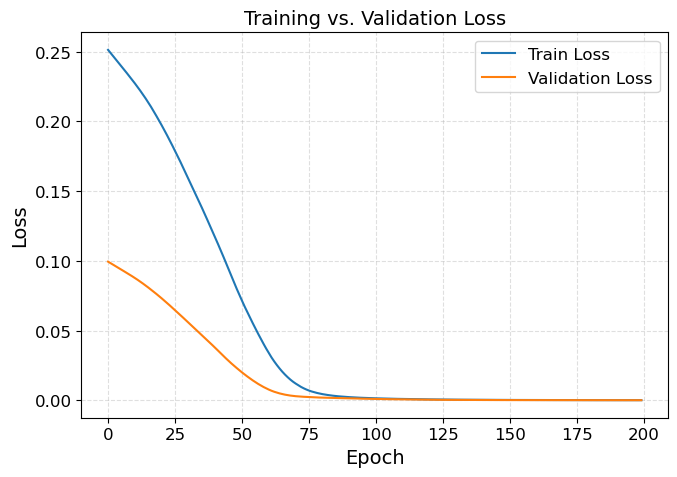

In [7]:

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
# Grid, legend, and tight layout
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='best')
fig.tight_layout()

plt.show()

### Check the prediction of the Validation Set

In [8]:
u_pred = my_model.predict(X_validation)
print(u_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
(18, 100, 5)


#### This is the Validation set prediction

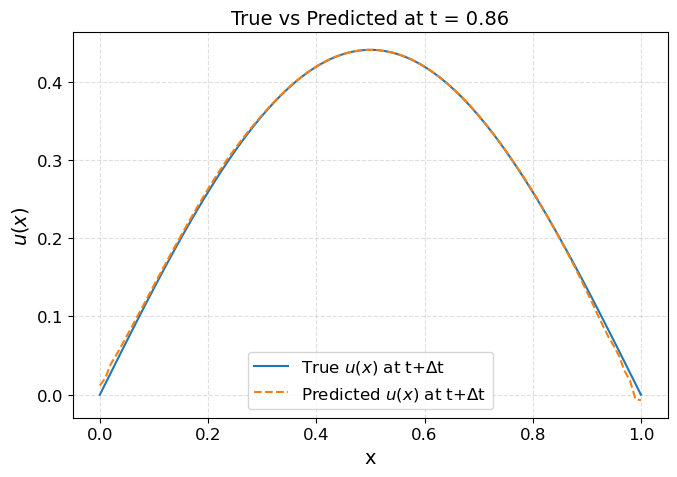

In [9]:

files = sorted([f for f in os.listdir(output_dir) if f.startswith('data_') and f.endswith('.csv')])
nt = len(files)
var_t = np.zeros((nt))
for i, file in enumerate(files):
    data = pd.read_csv(os.path.join(output_dir, file))
    var_t[i] = data["t"].iloc[0]



i=15
split_frac = int(0.8 * (nt - holdout))
ind_t = split_frac + i
time = np.round(var_t[ind_t], 2)
# which test example to look at

fig,ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(xdata, Y_validation[i, :, 0], label='True $u(x)$ at t+Δt')
plt.plot(xdata, u_pred[i, :, 0], '--', label='Predicted $u(x)$ at t+Δt')

plt.legend()
plt.xlabel('x')
plt.ylabel('$u(x)$')
plt.title("True vs Predicted at t = {}".format(time))
# Grid, legend, and tight layout
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(loc='best')
fig.tight_layout()

plt.show()

### Test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/var/folders/0v/kl9fb13d2v51vwxc37zr5__00000gn/T/ipykernel_21874/1118782231.py:19: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(xdata, (Y_test[0, :, 0]-u_pred_test[0, :, 0])/Y_test[0, :, 0], label='t+Δt')
/var/folders/0v/kl9fb13d2v51vwxc37zr5__00000gn/T/ipykernel_21874/1118782231.py:20: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(xdata, (Y_test[4, :, 1]-u_pred_test[0, :, 4])/Y_test[4, :, 1], label='t+5Δt')


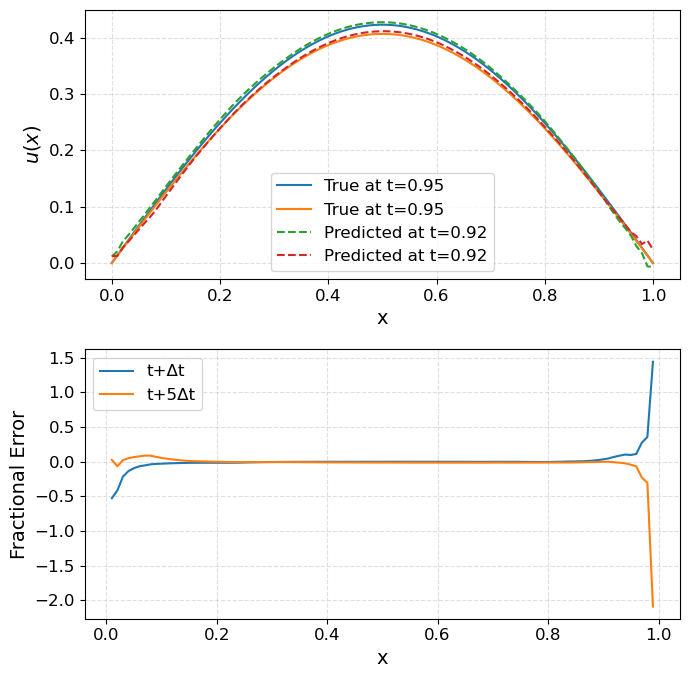

In [10]:
u_pred_test = my_model.predict(X_test)

fig,(ax1, ax2) = plt.subplots(2,1,figsize=(7,7))
ax1.plot(xdata, Y_test[1,:,0], label=f"True at t={var_t[nt - holdout + 5]:.2f}")
ax1.plot(xdata, Y_test[4, :, 1], label=f"True at t={var_t[nt - holdout + 5]:.2f}")

ax1.plot(xdata, u_pred_test[0, :, 0], '--', label=f"Predicted at t={var_t[nt - holdout + 2]:.2f}")
ax1.plot(xdata, u_pred_test[0, :, 4], '--', label=f"Predicted at t={var_t[nt - holdout + 2]:.2f}")

ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('$u(x)$')

# Grid, legend, and tight layout
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(loc='best')


ax2.plot(xdata, (Y_test[0, :, 0]-u_pred_test[0, :, 0])/Y_test[0, :, 0], label='t+Δt')
ax2.plot(xdata, (Y_test[4, :, 1]-u_pred_test[0, :, 4])/Y_test[4, :, 1], label='t+5Δt')


ax2.legend()
plt.xlabel('x')
plt.ylabel('Fractional Error')
ax2.grid(True, linestyle='--', alpha=0.4)

fig.tight_layout()
plt.show()